<a href="https://colab.research.google.com/github/genealston/googlecolab/blob/main/rf_train_test_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pandas
!pip install --quiet optuna
!pip install --quiet shap
!pip install --quiet gdown
!pip install --quiet tensorflow tensorflow_decision_forests

import os  
import numpy as np 
import pandas as pd
import tensorflow as tf 
import math

import datetime as dt
import random
import optuna
import shap

from sklearn.utils import resample
from keras import models
from keras import layers
from tensorflow.keras import initializers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt

# Decision Tree with Random Forest
import tensorflow_decision_forests as tfdf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.3 MB/s eta 0:00:00
Found TensorFlow Decision Forests v1.3.0


In [3]:
#Load Pickled Dataframe from cleaned data stage
!gdown 'https://drive.google.com/uc?id=1LA6dJJ5tn8oTSWO-Thx2PizItjikfmdP'
crime = pd.read_pickle('/content/crime_final.pkl') 
len(crime)

Downloading...
From: https://drive.google.com/uc?id=1LA6dJJ5tn8oTSWO-Thx2PizItjikfmdP
To: /content/crime_final.pkl
100% 4.91G/4.91G [00:20<00:00, 235MB/s]


354515

In [ ]:
crime.head(10)

In [ ]:
#Find unique values and value counts in target column
crime['force_outcome'].nunique()
crime['force_outcome'].unique()

In [4]:
#shuffle df prior to split 
np.random.seed(1234)
crime_splits = crime.sample(frac = 1)

#Below we are creating splits for training and test
#70% of our data will be training and validation (60% training, 10% validation), 30% will be test data
split = (0.6,0.3,.1)

#take training split first
crime_train = crime_splits.sample(frac = split[0]) 
crime_splits = crime_splits.drop(crime_train.index)

#scale up test split to account for missing training split
crime_test = crime_splits.sample(frac = split[1]/(1-split[0])) 
crime_splits = crime_splits.drop(crime_test.index)

#residual goes to validation 
crime_validation = crime_splits

#double check the lengths  
print('Training Data Shape', crime_train.shape)
print('Validation Data Shape', crime_validation.shape)
print('Test Data Shape', crime_test.shape)

Training Data Shape (212709, 1736)
Validation Data Shape (35452, 1736)
Test Data Shape (106354, 1736)


In [5]:
#There is a large class imbalance in our data
print("This is counts of our data before upsampling \n", crime_train['force_outcome'].value_counts()) 
#as a result upsampling of our minority class is required for training data
crime_train_majority = crime_train[crime_train['force_outcome']==0]
crime_train_minority = crime_train[crime_train['force_outcome']!=0] 
print("The Length of the majority class is", len(crime_train_majority)) 
print("The Length of the minority class is", len(crime_train_minority)) 

sample_dif = len(crime_train_majority) - len(crime_train_minority)

# Upsample minority class
crime_train_upsampled = resample(crime_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=sample_dif,    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
crime_train = pd.concat([crime_train_majority.copy(), crime_train_upsampled.copy()]).sample(frac = 1)

print("This is counts of our data after upsampling \n", crime_train['force_outcome'].value_counts())  

#Delete temp dataframes to perserve memory 
del crime_train_majority, crime_train_minority

This is counts of our data before upsampling 
 0    203970
1      5241
2      3471
3        27
Name: force_outcome, dtype: int64
The Length of the majority class is 203970
The Length of the minority class is 8739
This is counts of our data after upsampling 
 0    203970
1    117111
2     77496
3       624
Name: force_outcome, dtype: int64


In [ ]:
#Get the Number of Features in our Model for Input Layer
input_length = crime_train.shape[1]-1
print("The Number of features in the training data is", input_length) 

#Calculate the number of classes for outcomes for output layer
ouput_legnth = crime_train['force_outcome'].nunique()
print("The Number of classes in our output data is", ouput_legnth)

In [6]:
# define the target column and create TensorFlow datasets
target = 'force_outcome'
train_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(crime_train, label=target, task=tfdf.keras.Task.CLASSIFICATION)
test_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(crime_test, label=target, task=tfdf.keras.Task.CLASSIFICATION)


In [52]:
# save tensor datasets for future use

#def custom_shard_func(element):
#    return np.int64(0)

#train_tfds.save(path="/content/")
#test_tfds.save(path="/content/")

In [ ]:
# do some file clean up to save RAM
del crime_train, crime_validation, crime_test, crime, crime_splits, crime_train_upsampled

In [7]:
# instantiate the model
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# optional step - add evaluation metrics
model_rf.compile(metrics=["mse", "mape"])

# fit the model
# "sys_pipes" is optional and it enables the display of the training logs
with sys_pipes():
  model_rf.fit(x=train_tfds)

#model_rf.fit(x=train_tfds)

Use /tmp/tmp6w3mshvz as temporary training directory
Reading training dataset...


2023-04-09 17:04:08.095176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_218' with dtype double and shape [399201]
	 [[{{node Placeholder/_218}}]]


Training dataset read in 0:11:11.501736. Found 399201 examples.
Training model...


[INFO 23-04-09 17:56:03.7981 UTC kernel.cc:1242] Loading model from path /tmp/tmp6w3mshvz/model/ with prefix 5e0088f70b2b4e39
[INFO 23-04-09 17:56:10.5892 UTC decision_forest.cc:660] Model loaded with 300 root(s), 246674 node(s), and 658 input feature(s).
[INFO 23-04-09 17:56:10.5893 UTC abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 23-04-09 17:56:10.5903 UTC kernel.cc:1074] Use fast generic engine


Model trained in 0:40:54.158757
Compiling model...


2023-04-09 17:56:14.650296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_464' with dtype double and shape [399201]
	 [[{{node Placeholder/_464}}]]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [38]:
evaluation = model_rf.evaluate(test_tfds, return_dict=True)

print(evaluation)
print(f"MSE: {evaluation['mse']:.2f}")
print(f"RMSE: {math.sqrt(evaluation['mse']):.2f}")
print(f"MAPE: {evaluation['mape']:.2f}")

107/107 [==============================] - 159s 1s/step - loss: 0.0000e+00 - mse: 0.3057 - mape: 239687616.0000
{'loss': 0.0, 'mse': 0.3057374060153961, 'mape': 239687616.0}
MSE: 0.31
RMSE: 0.55
MAPE: 239687616.00


In [39]:
model_rf.compile(metrics=["accuracy"])
evaluation = model_rf.evaluate(test_tfds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

107/107 [==============================] - 155s 1s/step - loss: 0.0000e+00 - accuracy: 0.9930

loss: 0.0000
accuracy: 0.9930


In [40]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=4)

In [ ]:
# inspect the importance of the features used in the model
#model_rf.make_inspector().variable_importances()

In [41]:
inspector = model_rf.make_inspector()
print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())
print("Evaluation metrics:",inspector.evaluation())

Model type: RANDOM_FOREST
Number of trees: 300
Objective: Classification(label=__LABEL, class=None, num_classes=4)
Input features: ["arrest_indicator_binary" (1; #1), "bodycam_ind_binary" (1; #2), "category_arrest_type_Additional_SPD_Charges_(used_by_Records_Only)" (1; #3), "category_arrest_type_Arrest_-_Declined_at_Jail" (1; #4), "category_arrest_type_CBO-not_booked" (1; #5), "category_arrest_type_CSC/CDF_(Crisis_Solution_Center_/Crisis_Diversion_Facility)" (1; #6), "category_arrest_type_External_Agency_Arrest_/_SPD_Case_(used_by_Records_only)" (1; #7), "category_arrest_type_Follow_Up_Arrest-Booked" (1; #8), "category_arrest_type_Identify_and_Release-Not_Booked" (1; #9), "category_arrest_type_New_Offense_With_Arrest-Booked" (1; #10), "category_arrest_type_Order_Violation-Booked" (1; #11), "category_arrest_type_Summons_or_Citation_(used_by_Records_only)" (1; #12), "category_arrest_type_Update_Defendant_(used_by_Records_Only)" (1; #13), "category_arrest_type_Warrant_/_Detainer-Booked" (

In [ ]:
#print(f"Available variable importances:")
#for importance in inspector.variable_importances().keys():
#  print("\t", importance)

#inspect the importance of the features used in the model
inspector.variable_importances()["INV_MEAN_MIN_DEPTH"]

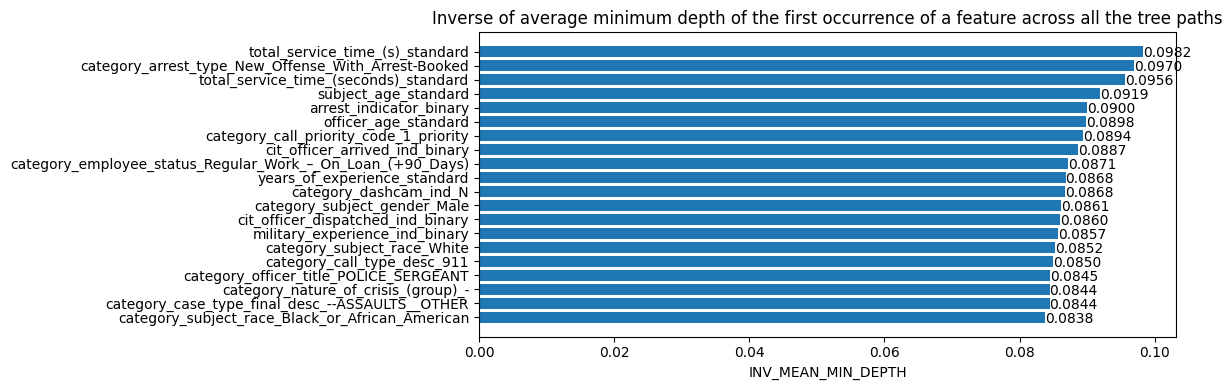

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "INV_MEAN_MIN_DEPTH"
variable_importances = inspector.variable_importances()[variable_importance_metric][:20]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("Inverse of average minimum depth of the first occurrence of a feature across all the tree paths")
plt.tight_layout()
plt.show()

In [44]:
import collections

# number_of_use[F] will be the number of node using feature F in its condition.
number_of_use = collections.defaultdict(lambda: 0)

# Iterate over all the nodes in a Depth First Pre-order traversals.
for node_iter in inspector.iterate_on_nodes():

  if not isinstance(node_iter.node, tfdf.py_tree.node.NonLeafNode):
    # Skip the leaf nodes
    continue

  # Iterate over all the features used in the condition.
  # By default, models are "oblique" i.e. each node tests a single feature.
  for feature in node_iter.node.condition.features():
    number_of_use[feature] += 1

print("Number of condition nodes per features:")
for x,y in sorted(number_of_use.items(), key=lambda k_v: k_v[1], reverse = True)[:30]:
    print("\t", x, ":", y)

Number of condition nodes per features:
	 "total_service_time_(s)_standard" (1; #1733) : 9678
	 "years_of_experience_standard" (1; #1735) : 4670
	 "total_service_time_(seconds)_standard" (1; #1734) : 4530
	 "category_arrest_type_New_Offense_With_Arrest-Booked" (1; #10) : 3453
	 "category_exhibiting_behavior_(group)_Behavior_–_Belligerent_/_Uncooperative" (1; #1026) : 2661
	 "subject_age_standard" (1; #1730) : 2469
	 "officer_age_standard" (1; #1728) : 2298
	 "category_exhibiting_behavior_(group)_Behavior_–_Physically_threatening_/_Aggressive" (1; #1038) : 1914
	 "category_exhibiting_behavior_(group)_Behavior_–_Disorderly_/_Disruptive" (1; #1028) : 1666
	 "category_case_type_final_desc_--ASSAULTS__OTHER" (1; #416) : 1362
	 "category_call_priority_code_1_priority" (1; #382) : 1250
	 "category_exhibiting_behavior_(group)_Behavior_–_Suicide_Threat_/_Attempt" (1; #1039) : 1170
	 "category_exhibiting_behavior_(group)_Behavior_–_Verbally_threatening_/_Aggressive" (1; #1042) : 1163
	 "category

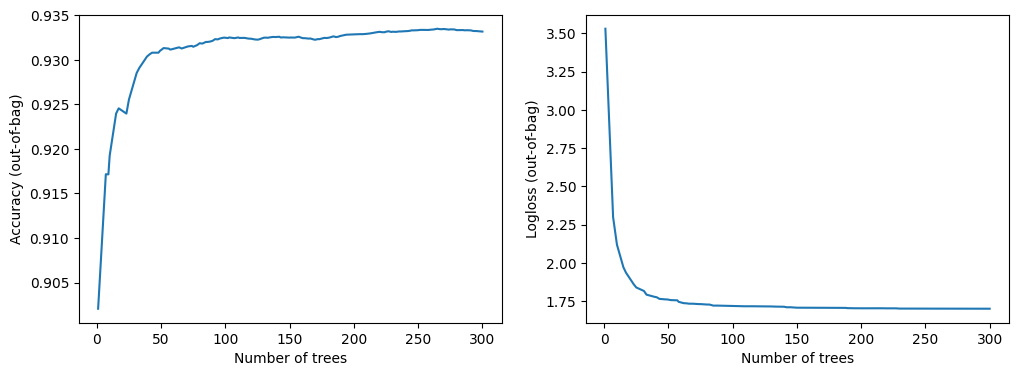

In [45]:
# plot the RMSE during training 
logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# New Section

In [ ]:
#model_rf.save('project/crime_tfdf')

In [ ]:
#import tensorflow_datasets as tfds
#ds_train = tfds.load('train_tfds',data_dir='/content/12520323268735278437/00000000.shard/00000000.snapshot')
#ds_test = tfds.load('train_tfds',data_dir='/content/3377570575826587746/00000000.shard/00000000.snapshot')